In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

%matplotlib inline

import os

In [2]:
import pickle
from langdetect import detect
import nltk

## Download and Preprocessing

In [53]:
#Downloaded from private url, need new token every time
url = 'https://raw.githubusercontent.com/thomasnilsson/02805-social-graphs-2018/master/project1/toronto/toronto_reviews_4.csv?token=AMgAjUSVn0RwgavtesFGRj3TIyz5pXEhks5cB6acwA%3D%3D'

In [54]:
reviews = pd.concat([reviews, pd.read_csv(url)])

In [167]:
reviews2.to_pickle('./Toronto_data/reviews_df.pkl')

In [3]:
#Load Pickles
reviews = pd.read_pickle('./Toronto_data/reviews_df.pkl')
businesses = pd.read_pickle('./Toronto_data/businesses_df.pkl')
users = pd.read_pickle('./Toronto_data/users_df.pkl')

In [27]:
#Define set of english words
english_vocab = set(w.lower() for w in nltk.corpus.words.words())
#english_vocab |= set(['refuse','rudest','vibes','sexist','belittle','scurry','shittiest','appalled','emailed',
#                     'discriminate','acknowledgment','mismanage','humiliate','accuse','foulest'])

In [ ]:
#Removes non-english reviews (~900)
non_english = []
for rev in reviews.iloc[:].itertuples():
    try:
        if not detect(rev.text) == 'en':
            non_english.append(rev)
    except:
        continue

#copy original reviews and delete the non english ones
rev_ids = [i.review_id for i in non_english]
reviews_all = reviews.copy()

for i,rev_id in enumerate(rev_ids):
    reviews = reviews[~(reviews['review_id']==rev_id)]

In [ ]:
reviews.to_pickle('./Toronto_data/reviews_edit_df.pkl')

In [4]:
#Dictionary of users who have attained lite status and those years of eliteness
elite_dict = {u.user_id:u.elite.split(',') for u in users.itertuples() if not u.elite == 'None'}

## Text Analysis

In [30]:
import nltk, re, pprint
from nltk import word_tokenize
from collections import Counter
import csv
from nltk.stem.wordnet import WordNetLemmatizer

In [31]:
path = '../labMT.txt'
reader = csv.reader(open(path), delimiter='\t')
lines = [l for l in reader]
header = lines[3]
labMT = lines[4:] 

In [33]:
#Words already processed in order to reduce time complexity
processed_english = {} #key: reduced word, sentiment
nonenglish_words = []

In [98]:
#Elite and regular 
elite_english = {i:Counter() for i in range(1,6)}
elite_ne = {i:Counter() for i in range(1,6)}

reg_english= {i:Counter() for i in range(1,6)}
reg_ne= {i:Counter() for i in range(1,6)}

In [99]:
elite_sent = {i:[] for i in range(1,6)}
reg_sent = {i:[] for i in range(1,6)}

In [100]:
elite_english_len = {i:[] for i in range(1,6)}
elite_ne_len = {i:[] for i in range(1,6)}

reg_english_len = {i:[] for i in range(1,6)}
reg_ne_len = {i:[] for i in range(1,6)}

In [235]:
id1 = 'xW1xg1VdqQtb_9B0i80nwA'
id2 = 'mH8UvY1RjUTjfKejkIxPzA'
l1 = []
l2 = []
for i,rev in enumerate(reviews.iloc[0:].itertuples()): #30000:100000
    if rev.user_id == id1:
        l1.append(rev)
    elif rev.user_id == id2:
        l2.append(rev)

In [240]:
list(set([i.business_id for i in l1]).union(set([i.business_id for i in l2])))[0]

'8al-XRt5nuIize8_STWffQ'

In [242]:
for i in list(set([i.business_id for i in l1]).union(set([i.business_id for i in l2])))[0]:
    for r in l1:
        if r.business_id == i:
            print(r)
    for r in l2:
        if r.business_id == i:
            print(r)

In [102]:
#current = 0

In [105]:
toStart = current
for i,rev in enumerate(reviews.iloc[toStart:].itertuples()): #30000:100000
    #Preprocessing
    txt = word_tokenize(rev.text)
    txt = [t.lower() for t in txt if re.search('^[a-zA-Z]+$',t)] #Removes numbers/punctuation
    #txt = [nltk.PorterStemmer().stem(t) for t in txt] #Stems the words
    txt = [t for t in txt if t not in nltk.corpus.stopwords.words('english')] #remove stopwords
    
    sentiment = []
    english = []
    non_english = []
    for t in txt:
        is_english = True
        new_t = None
        #Find english form
        if t in processed_english.keys():
            new_t,sent = processed_english[t]
            english.append(new_t),sentiment.append(sent)
            continue
        elif t in nonenglish_words:
            non_english.append(t)
            continue
        elif t in english_vocab:
            new_t = t 
        elif nltk.SnowballStemmer('english').stem(t) in english_vocab:
            new_t = nltk.SnowballStemmer('english').stem(t)
        elif WordNetLemmatizer().lemmatize(t,'v') in english_vocab:
            new_t = WordNetLemmatizer().lemmatize(t,'v')
        elif WordNetLemmatizer().lemmatize(t,'a') in english_vocab:
            new_t = WordNetLemmatizer().lemmatize(t,'a')
        else:
            is_english = False
            
        #Indentify sentiment and update
        if is_english:
            english.append(t)
            processed_english[t] = (new_t, 0)
            for item in labMT: 
                if (t == item[0]): 
                    sent = float(item[2])
                    processed_english[t] = (new_t, sent)
                    sentiment.append(sent)
                    break
        else:
            nonenglish_words.append(t)
            non_english.append(t)
    
    
    if rev.user_id in elite_dict.keys() and rev.date.split('-')[0] in elite_dict[rev.user_id]:
        elite_english[rev.stars].update(english)
        elite_ne[rev.stars].update(non_english)
        
        elite_english_len[rev.stars].append(len(english))
        elite_ne_len[rev.stars].append(len(non_english))
        
        elite_sent[rev.stars].append(sentiment)
    else:
        reg_english[rev.stars].update(english)
        reg_ne[rev.stars].update(non_english)
        
        reg_english_len[rev.stars].append(len(english))
        reg_ne_len[rev.stars].append(len(non_english))
        
        reg_sent[rev.stars].append(sentiment)
    
    if ((i+1)%1000) == 0:
        current = current + 1000
        print(current)
        save_progress(True)
        
        elite_english = {i:Counter() for i in range(1,6)}
        elite_ne = {i:Counter() for i in range(1,6)}

        reg_english= {i:Counter() for i in range(1,6)}
        reg_ne= {i:Counter() for i in range(1,6)}

        elite_sent = {i:[] for i in range(1,6)}
        reg_sent = {i:[] for i in range(1,6)}

        elite_english_len = {i:[] for i in range(1,6)}
        elite_ne_len = {i:[] for i in range(1,6)}

        reg_english_len = {i:[] for i in range(1,6)}
        reg_ne_len = {i:[] for i in range(1,6)}

71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
174000
175000
176000
177000
178000
179000
180000
181000
182000
183000
184000
185000
186000
187000
188000
189000
190000
191000
192000
193000
194000
195000
196000
197000
198000
199000
200000
201000
202000
203000
204000
205000
206000
207000
208000
209000
210000
211000
212000
213000
214000
215000
216000
217000


In [108]:
print(i)
save_progress(True)

308973


In [101]:
check = False
if check:
    with open('./Toronto_data/elite_ne.pickle', 'wb') as handle:
        pickle.dump(elite_ne, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('./Toronto_data/elite_english.pickle', 'wb') as handle:
        pickle.dump(elite_english, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('./Toronto_data/elite_sent.pickle', 'wb') as handle:
        pickle.dump(elite_sent, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('./Toronto_data/elite_english_len.pickle', 'wb') as handle:
        pickle.dump(elite_english_len, handle, protocol=pickle.HIGHEST_PROTOCOL)    
        
    with open('./Toronto_data/elite_ne_len.pickle', 'wb') as handle:
        pickle.dump(elite_ne_len, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

    with open('./Toronto_data/reg_ne.pickle', 'wb') as handle:
        pickle.dump(reg_ne, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('./Toronto_data/reg_english.pickle', 'wb') as handle:
        pickle.dump(reg_english, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('./Toronto_data/reg_sent.pickle', 'wb') as handle:
        pickle.dump(reg_sent, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('./Toronto_data/reg_english_len.pickle', 'wb') as handle:
        pickle.dump(reg_english_len, handle, protocol=pickle.HIGHEST_PROTOCOL)    
        
    with open('./Toronto_data/reg_ne_len.pickle', 'wb') as handle:
        pickle.dump(reg_ne_len, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [90]:
def read_write(path, dtype,var):
    temp = None
    with open(path, 'rb') as handle:
        try:
            temp = pickle.load(handle)
        except:
            if dtype == 'counter': 
                temp = {i:Counter() for i in range(1,6)}
            elif dtype == 'list':
                temp = {i:[] for i in range(1,6)}
    with open(path, 'wb') as handle:
        if dtype == 'counter':
            pickle.dump({i:sum_counter([var[i], temp[i]]) for i in range(1,6)}, handle, protocol=pickle.HIGHEST_PROTOCOL)
        elif dtype == 'list':
            pickle.dump({i:(var[i] + temp[i]) for i in range(1,6)}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [91]:
check = False
def save_progress(check):
    
    if not check:
        print('Did not save')
        return
    read_write('./Toronto_data/elite_ne.pickle', 'counter', elite_ne)
    
    read_write('./Toronto_data/elite_english.pickle', 'counter', elite_english)
        
    read_write('./Toronto_data/elite_sent.pickle', 'list', elite_sent)
        
    read_write('./Toronto_data/elite_english_len.pickle', 'list',elite_english_len)    
        
    read_write('./Toronto_data/elite_ne_len.pickle', 'list', elite_ne_len)
        

    read_write('./Toronto_data/reg_ne.pickle', 'counter', reg_ne)
    
    read_write('./Toronto_data/reg_english.pickle', 'counter', reg_english)
        
    read_write('./Toronto_data/reg_sent.pickle', 'list', reg_sent)
        
    read_write('./Toronto_data/reg_english_len.pickle', 'list',reg_english_len)    
        
    read_write('./Toronto_data/reg_ne_len.pickle', 'list', reg_ne_len)

In [25]:
with open('./Toronto_data/elite_english.pickle', 'rb') as handle:
        elite_english = pickle.load(handle)
        
with open('./Toronto_data/reg_english.pickle', 'rb') as handle:
        reg_english = pickle.load(handle)

In [110]:
check = True
if check:
    with open('./Toronto_data/elite_ne.pickle', 'rb') as handle:
        elite_ne = pickle.load(handle)
        
    with open('./Toronto_data/elite_english.pickle', 'rb') as handle:
        elite_english = pickle.load(handle)
        
    with open('./Toronto_data/elite_sent.pickle', 'rb') as handle:
        elite_sent = pickle.load(handle)
        
    with open('./Toronto_data/elite_english_len.pickle', 'rb') as handle:
        elite_english_len = pickle.load(handle)   
        
    with open('./Toronto_data/elite_ne_len.pickle', 'rb') as handle:
        elite_ne_len = pickle.load(handle)
        

    with open('./Toronto_data/reg_ne.pickle', 'rb') as handle:
        reg_ne = pickle.load(handle)
        
    with open('./Toronto_data/reg_english.pickle', 'rb') as handle:
        reg_english = pickle.load(handle)
        
    with open('./Toronto_data/reg_sent.pickle', 'rb') as handle:
        reg_sent= pickle.load(handle)
        
    with open('./Toronto_data/reg_english_len.pickle', 'rb') as handle:
        reg_english_len = pickle.load(handle)  
        
    with open('./Toronto_data/reg_ne_len.pickle', 'rb') as handle:
        reg_ne_len = pickle.load(handle)

In [12]:
def tf_idf(docs):
    N = len(docs)
    #IDF
    idf = {}
    for doc in docs:
        for term in doc.keys():
            if term not in idf.keys():
                idf[term] = 1
            else:
                idf[term] += 1
    
    #TF-IDF
    for doc in docs:
        for term in doc.keys():
            #TF * IDF
            doc[term] = doc[term] * np.log(N / (idf[term]))
    
    return docs

In [13]:
def sum_counter(counters):
    cntr = Counter()
    for c in counters:
        cntr = cntr + c
    return cntr

In [14]:
tfidfs = tf_idf([sum_counter(elite_english.values()),sum_counter(reg_english.values())])

In [993]:
names = ['Elites','Regular']

In [114]:
tfidfs = tf_idf([i for i in elite_english.values()] + [i for i in reg_english.values()])

In [115]:
names = ['Elite Reviewers 1 Star TF-IDF Cloud',
         'Elite Reviewers 2 Star TF-IDF Cloud',
         'Elite Reviewers 3 Star TF-IDF Cloud',
         'Elite Reviewers 4 Star TF-IDF Cloud',
         'Elite Reviewers 5 Star TF-IDF Cloud',
         'Regular Reviewers 1 Star TF-IDF Cloud',
         'Regular Reviewers 2 Star TF-IDF Cloud',
         'Regular Reviewers 3 Star TF-IDF Cloud',
         'Regular Reviewers 4 Star TF-IDF Cloud',
         'Regular Reviewers 5 Star TF-IDF Cloud',]

In [116]:
wordCloud = []
for tfidf in tfidfs:
    wordCloud.append(' '.join([' '.join([word]*abs(int(val))) for word,val in tfidf.items()]))

In [263]:
name = 'Elite Reviewers 1 Star TF-IDF Cloud'
with open(('./Toronto_data/%s.pickle' % name), 'rb') as handle:
        test = pickle.load(handle)

In [264]:
test

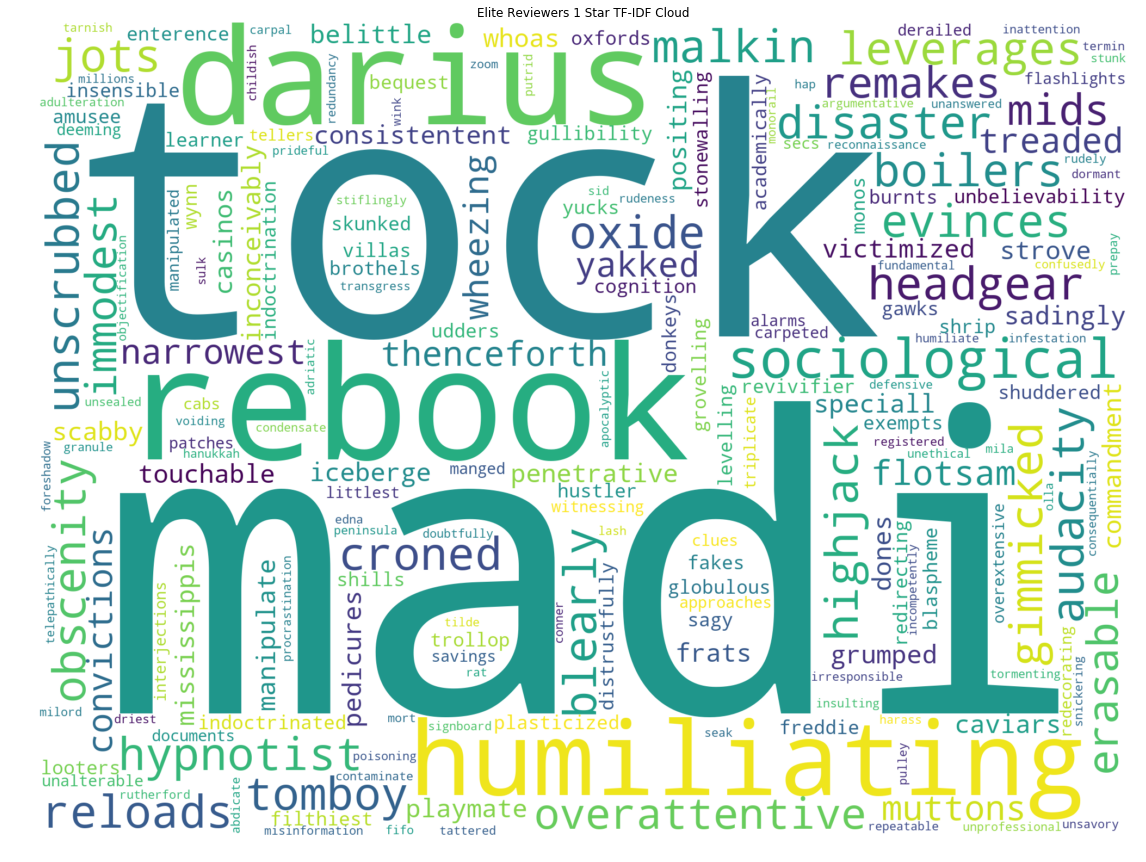

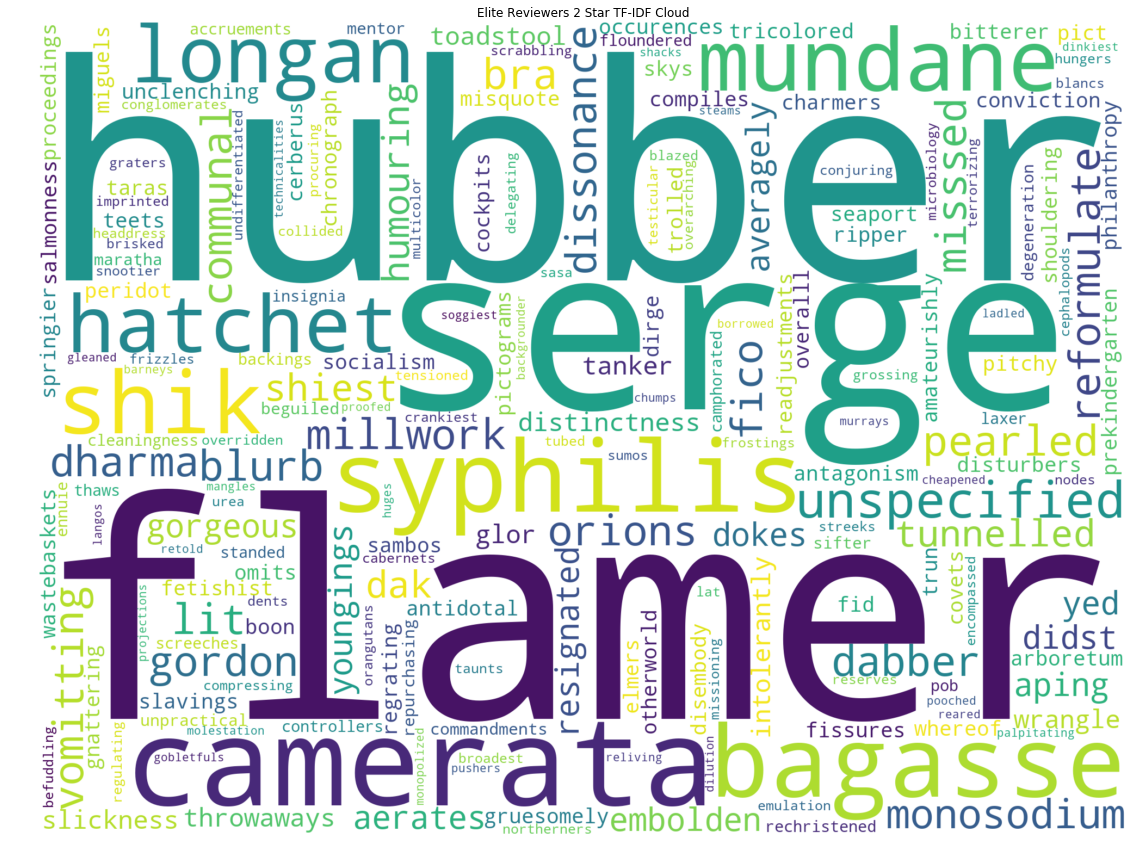

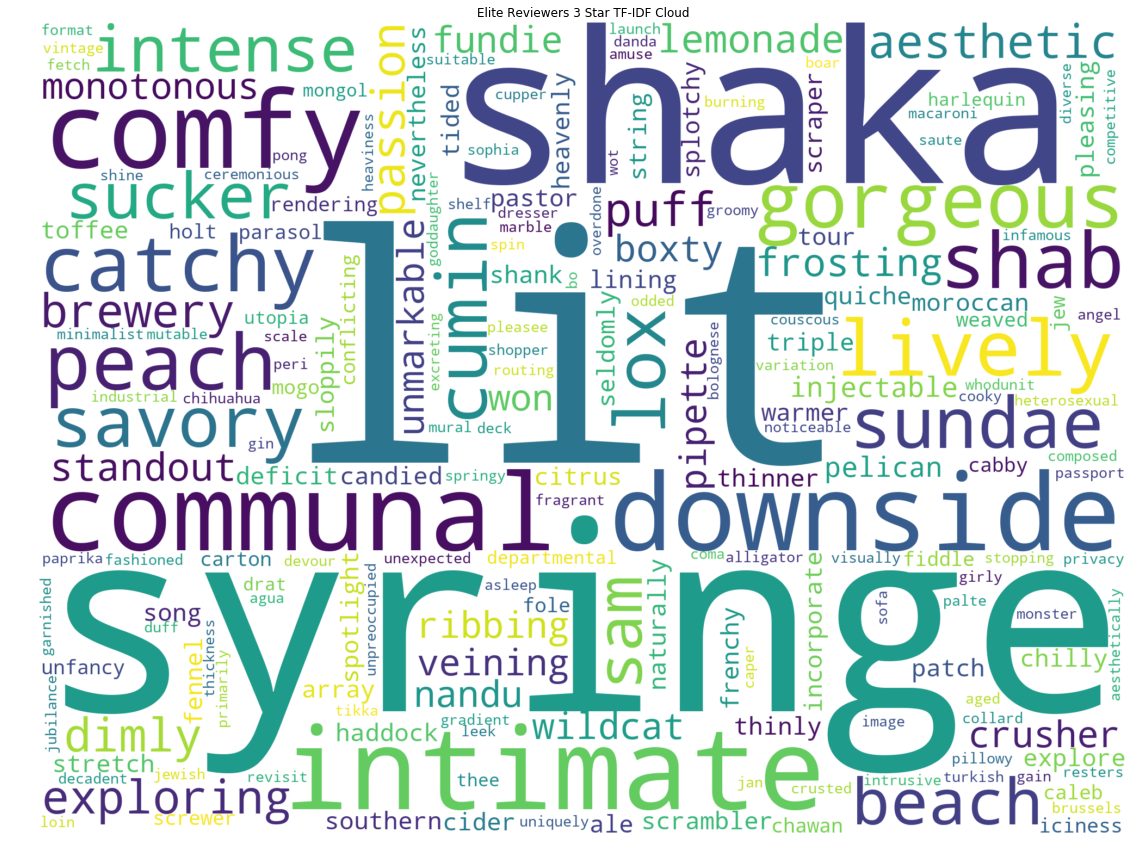

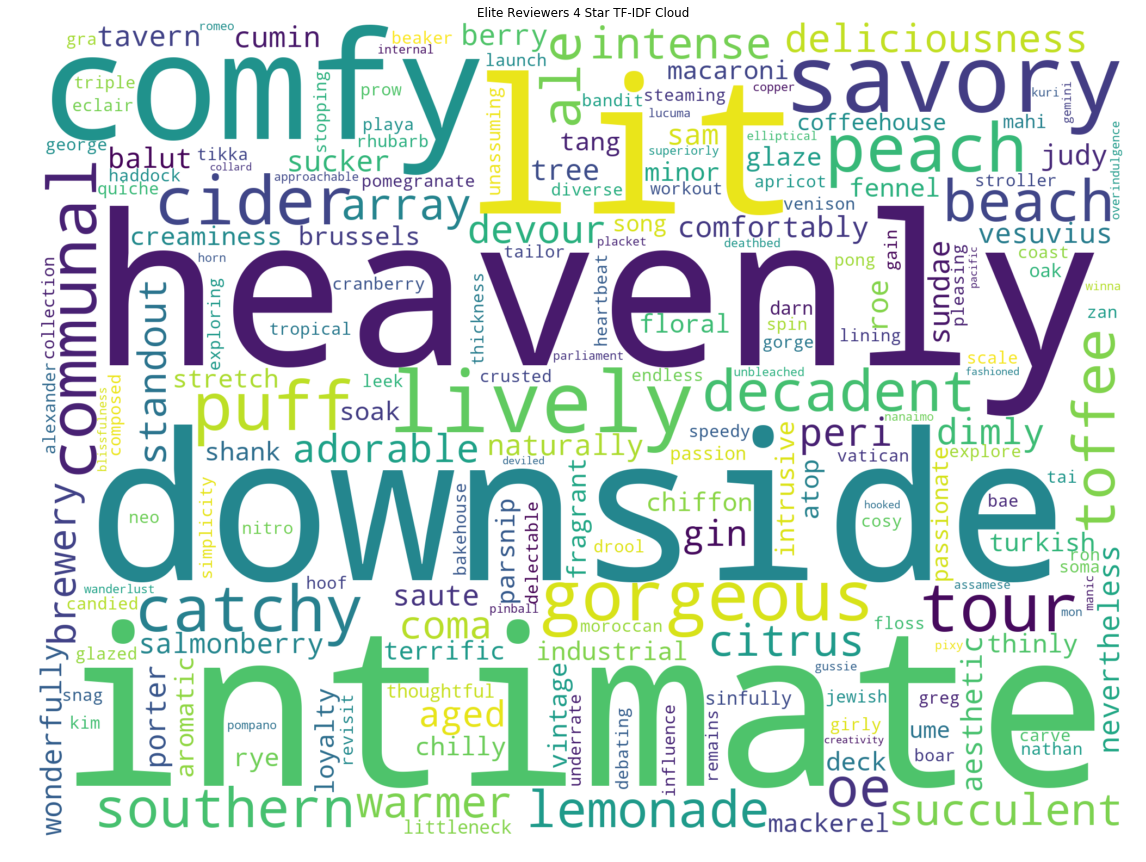

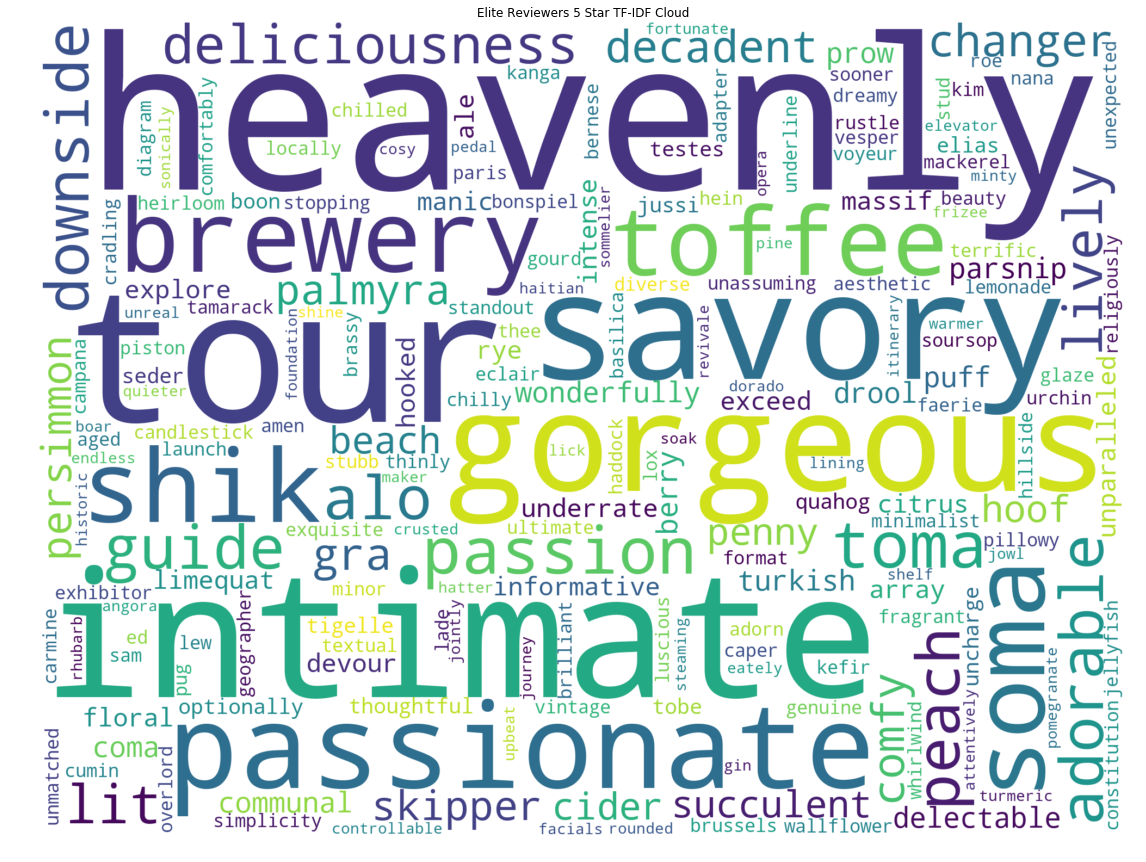

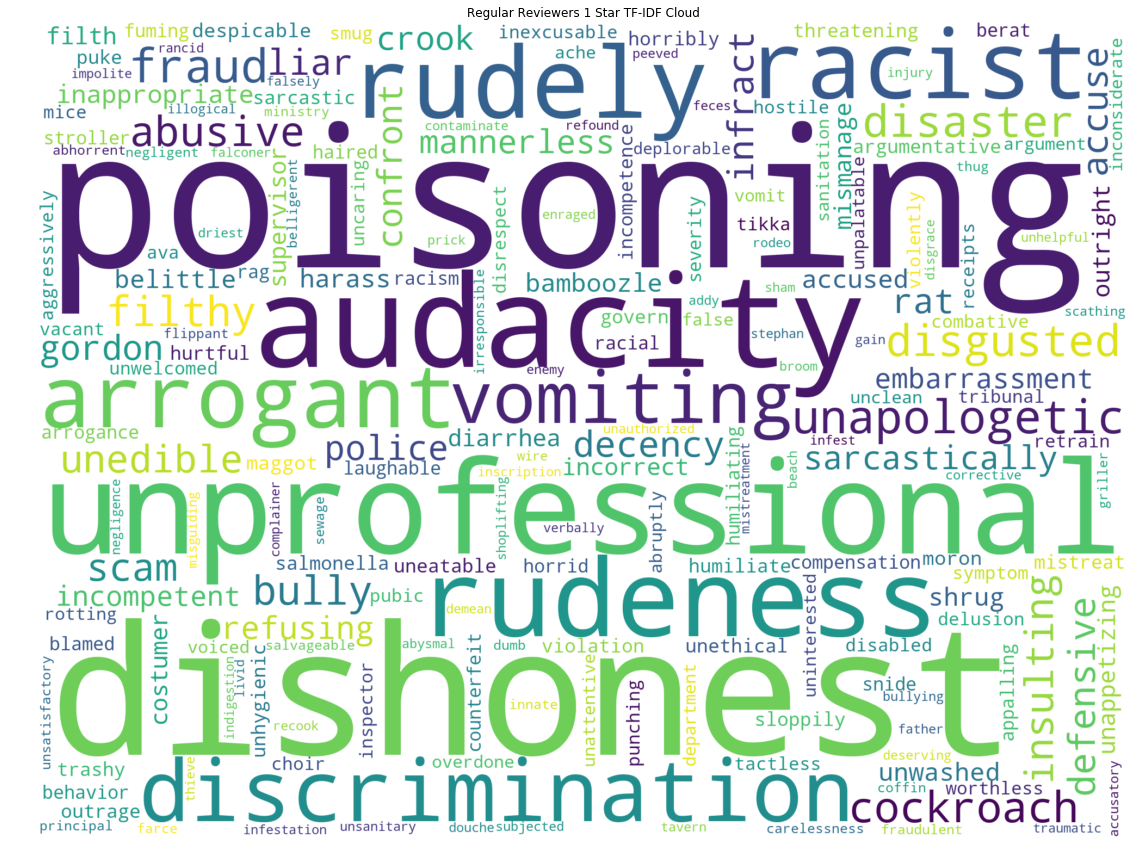

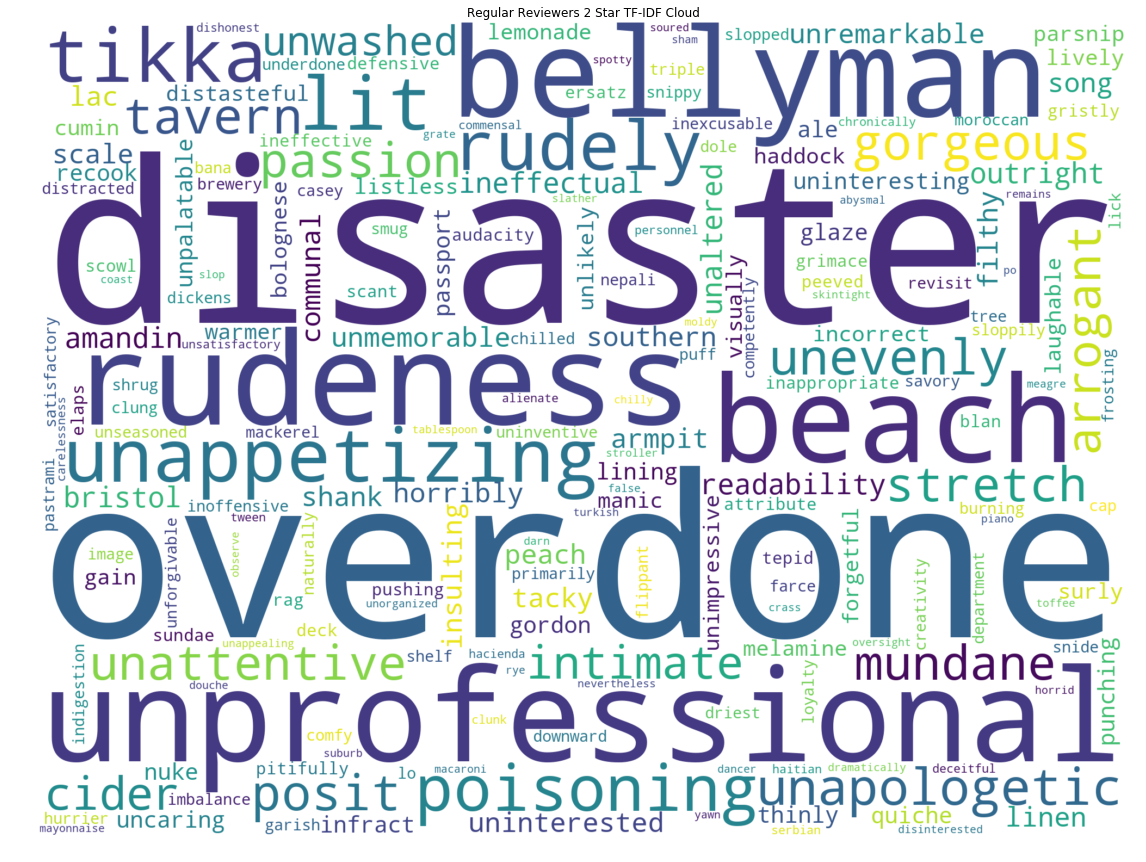

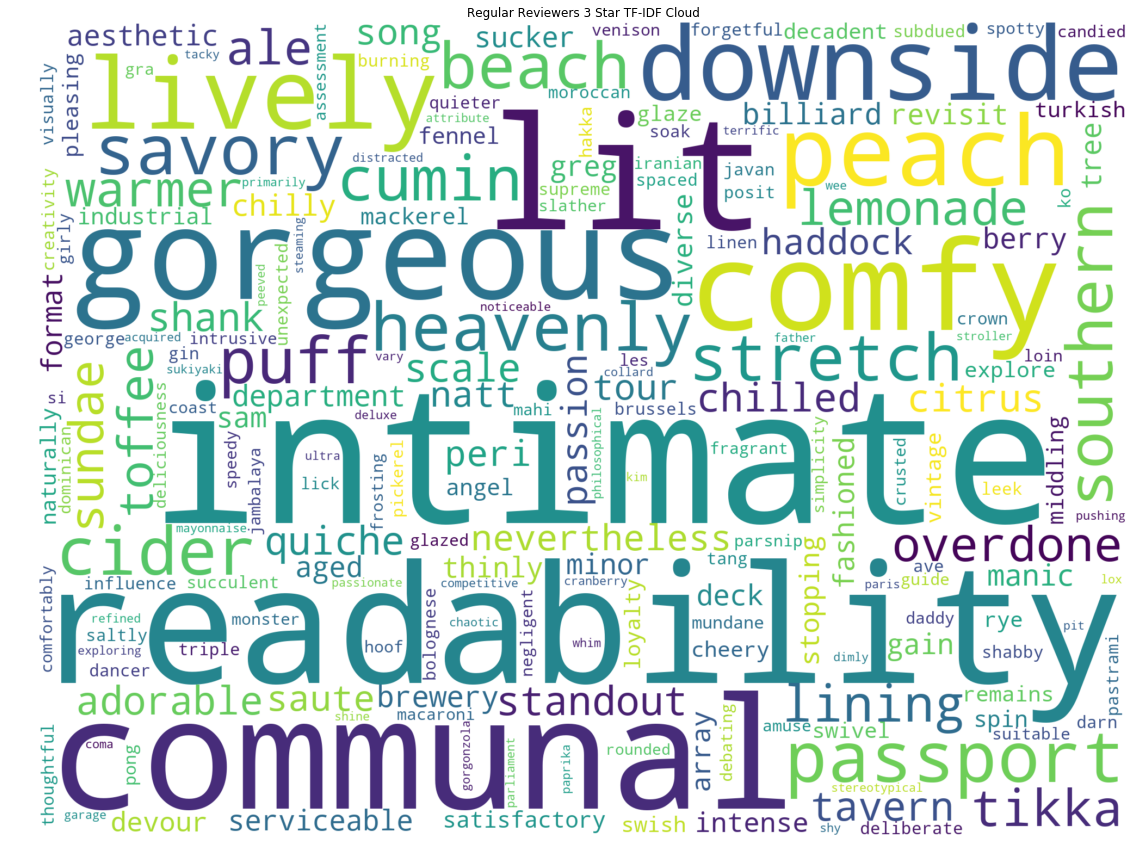

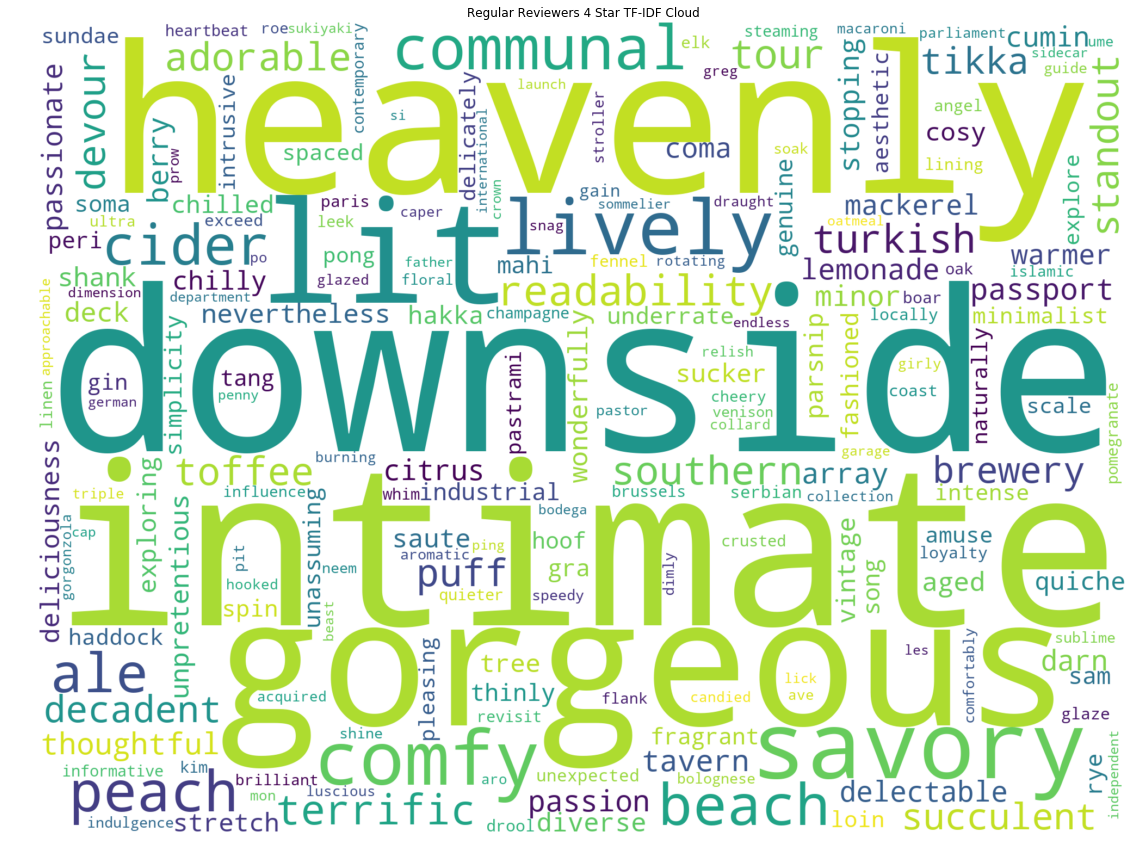

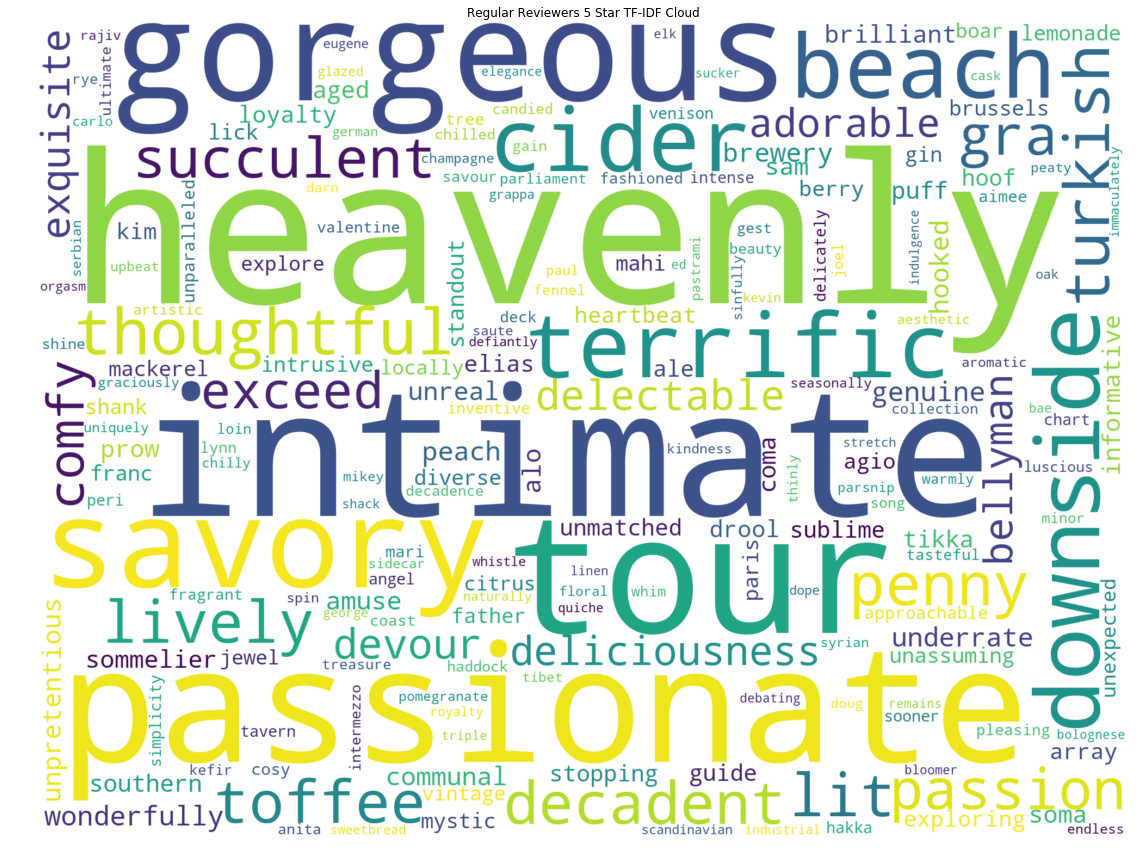

In [278]:
from wordcloud import WordCloud

for cloud,name in zip(wordCloud,names):
    # Generate a word cloud image
    # lower max_font_size
    wc = WordCloud(width=2000,height=1500,max_words=250,
                   collocations=False,background_color='white').generate(cloud)
    #with open(('./Toronto_data/%s.pickle' % name), 'wb') as handle:
    #    pickle.dump(wc, handle, protocol=pickle.HIGHEST_PROTOCOL)
    plt.figure()
    plt.figure(figsize=(20,15))
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(name)
    
    save = False
    if save:
        plt.savefig("SentimentPlots/%s.svg" % ('_'.join(name.split(' '))),format='svg')
        
    plt.show()

# Sentiment Analysis

In [525]:
import csv

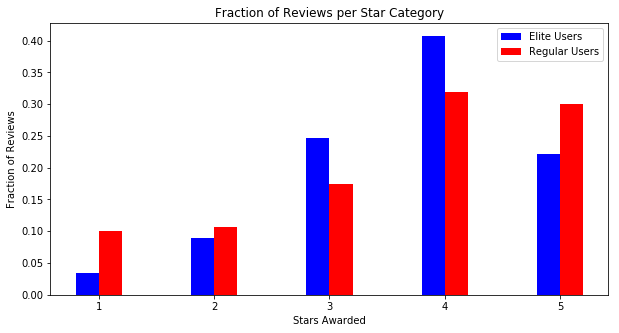

In [119]:
#fig,axes = plt.subplots(5, 2, sharex=True, sharey=True)
plt.figure(figsize=(10,5))
x = np.arange(1,6)
y_elite = np.array([len(elite_sent[i]) for i in x])
y_elite = y_elite / sum(y_elite)
y_reg = np.array([len(reg_sent[i]) for i in x])
y_reg = y_reg / sum(y_reg)

plt.bar(x-0.1, y_elite,width=0.2,color='b',align='center',label='Elite Users')
plt.bar(x+0.1, y_reg,width=0.2,color='r',align='center',label='Regular Users')

plt.legend()
plt.title('Fraction of Reviews per Star Category')
plt.xlabel('Stars Awarded')
plt.ylabel('Fraction of Reviews')
plt.xticks(x)
plt.show()

save = False
if save:
    plt.savefig("fraction_stars.svg")

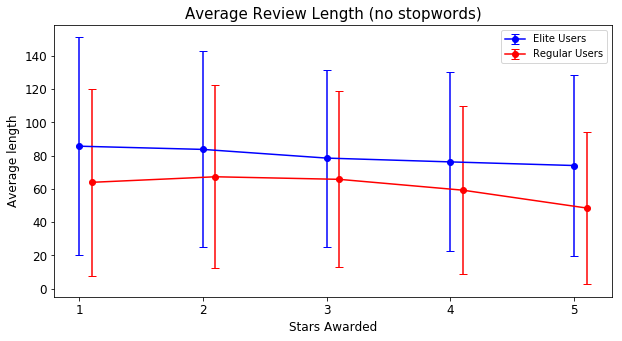

In [259]:
plt.figure(figsize=(10,5))
plt.title('Average Review Length (no stopwords)',fontsize=15)
plt.xlabel('Stars Awarded',fontsize=12)
plt.ylabel('Average length',fontsize=12)
x = np.arange(1,6)
plt.errorbar(x,[np.mean([i1+i2 for i1,i2 in zip(elite_english_len[i],elite_ne_len[i])]) for i in x],
             yerr=[np.std([i1+i2 for i1,i2 in zip(elite_english_len[i],elite_ne_len[i])]) for i in x],
             linestyle='-', marker='o',capsize=4,color='blue',label='Elite Users')
plt.errorbar(x+0.1,[np.mean([i1+i2 for i1,i2 in zip(reg_english_len[i],reg_ne_len[i])]) for i in x],
             yerr=[np.std([i1+i2 for i1,i2 in zip(reg_english_len[i],reg_ne_len[i])]) for i in x],
             linestyle='-', marker='o',capsize=4,color='red',label='Regular Users')
plt.legend()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

save = True
if save:
    plt.savefig("SentimentPlots/avg_review_length.svg")
    
plt.show()

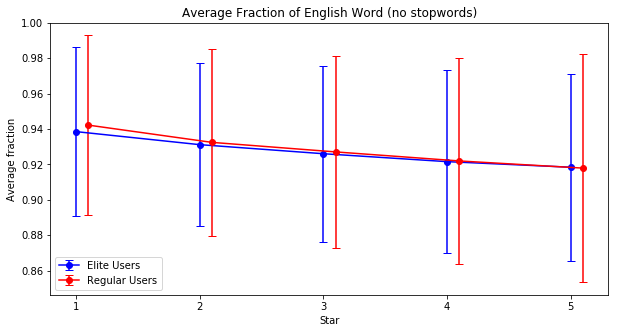

In [122]:
plt.figure(figsize=(10,5))
plt.title('Average Fraction of English Word (no stopwords)')
plt.xlabel('Star')
plt.ylabel('Average fraction')
x = np.arange(1,6)
plt.errorbar(x,[np.mean([i1/(i1+i2) for i1,i2 in zip(elite_english_len[i],elite_ne_len[i]) if i1+i2>0]) for i in x],
             yerr=[np.std([i1/(i1+i2) for i1,i2 in zip(elite_english_len[i],elite_ne_len[i]) if i1+i2>0]) for i in x],
             linestyle='-', marker='o',capsize=4,color='blue',label='Elite Users')
plt.errorbar(x+0.1,[np.mean([i1/(i1+i2) for i1,i2 in zip(reg_english_len[i],reg_ne_len[i]) if i1+i2>0]) for i in x],
             yerr=[np.std([i1/(i1+i2) for i1,i2 in zip(reg_english_len[i],reg_ne_len[i]) if i1+i2>0]) for i in x],
             linestyle='-', marker='o',capsize=4,color='red',label='Regular Users')
plt.legend()
plt.show()

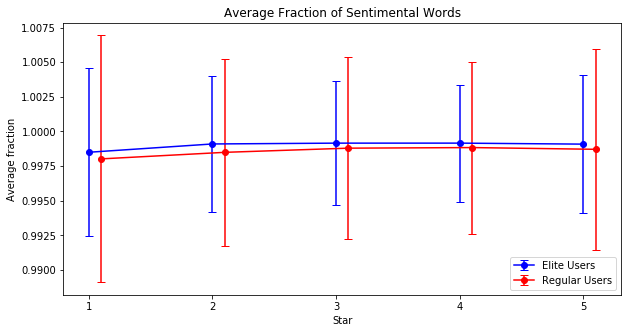

In [124]:
plt.figure(figsize=(10,5))
plt.title('Average Fraction of Sentimental Words')
plt.xlabel('Star')
plt.ylabel('Average fraction')
x = np.arange(1,6)
plt.errorbar(x,[np.mean([len(i1)/i2 for i1,i2 in zip(elite_sent[i],elite_english_len[i]) if i2>0]) for i in x],
             yerr=[np.std([len(i1)/i2 for i1,i2 in zip(elite_sent[i],elite_english_len[i]) if i2>0]) for i in x],
             linestyle='-', marker='o',capsize=4,color='blue',label='Elite Users')
plt.errorbar(x+0.1,[np.mean([len(i1)/i2 for i1,i2 in zip(reg_sent[i],reg_english_len[i]) if i2>0]) for i in x],
             yerr=[np.std([len(i1)/i2 for i1,i2 in zip(reg_sent[i],reg_english_len[i]) if i2>0]) for i in x],
             linestyle='-', marker='o',capsize=4,color='red',label='Regular Users')
plt.legend()
plt.show()

In [199]:
labMT_mean = np.mean([float(i[2]) for i in labMT])
labMT_std = np.std([float(i[2]) for i in labMT])
elite_sent_extrema = {i:[] for i in range(1,6)}
reg_sent_extrema = {i:[] for i in range(1,6)}

In [200]:
for i in range(1,6):
    for cnt,sents in zip(elite_english_len[i], elite_sent[i]):
        if len(sents)==0: continue
        l = 0; m = 0;h = 0
        for sent in sents:
            if sent < labMT_mean - 1*labMT_std:
                l += 1
            elif sent > labMT_mean + 1*labMT_std:
                h += 1
            else:
                m += 1
        total = l+m+h
        elite_sent_extrema[i].append((l/total,m/total,h/total))
for i in range(1,6):
    for cnt,sents in zip(reg_english_len[i], reg_sent[i]):
        if len(sents)==0: continue
        l=0; m = 0; h = 0
        for sent in sents:
            if sent < labMT_mean - 1*labMT_std:
                l += 1
            elif sent > labMT_mean + 1*labMT_std:
                h += 1
            else:
                m += 1
        total = l+m+h
        reg_sent_extrema[i].append((l/total,m/total,h/total))

In [194]:
for i in range(1,6):
    for cnt,sents in zip(elite_english_len[i], elite_sent[i]):
        if len(sents)==0: continue
        dist = [0,0,0,0,0]
        for sent in sents:
            if sent < labMT_mean - 2*labMT_std:
                dist[0]+=1
            elif sent < labMT_mean - 1*labMT_std:
                dist[1]+=1
            elif sent < labMT_mean + 1*labMT_std:
                dist[2]+=1
            elif sent < labMT_mean + 2*labMT_std:
                dist[3]+=1
            else:
                dist[4]+=1
        total = sum(dist)
        elite_sent_extrema[i].append([i/total for i in dist])
for i in range(1,6):
    for cnt,sents in zip(reg_english_len[i], reg_sent[i]):
        if len(sents)==0: continue
        dist = [0,0,0,0,0]
        for sent in sents:
            if sent < labMT_mean - 2*labMT_std:
                dist[0]+=1
            elif sent < labMT_mean - 1*labMT_std:
                dist[1]+=1
            elif sent < labMT_mean + 1*labMT_std:
                dist[2]+=1
            elif sent < labMT_mean + 2*labMT_std:
                dist[3]+=1
            else:
                dist[4]+=1
        total = sum(dist)
        reg_sent_extrema[i].append([i/total for i in dist])

0
1
2
3
4


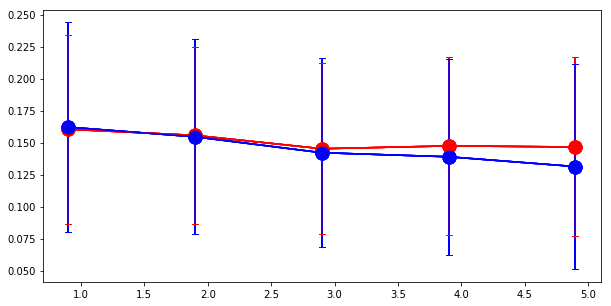

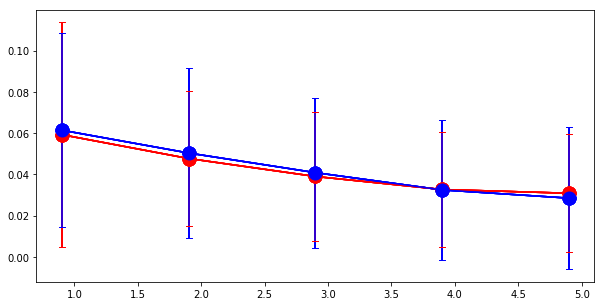

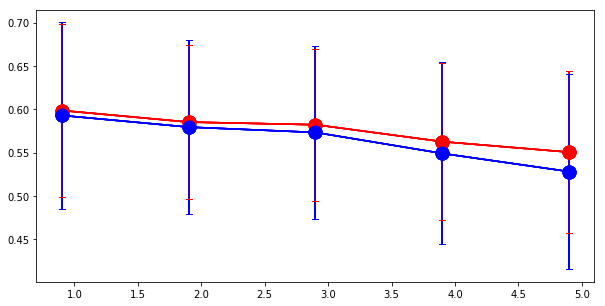

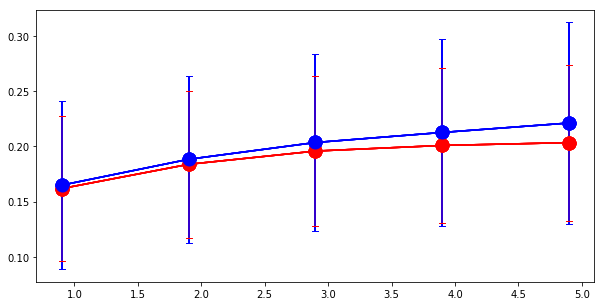

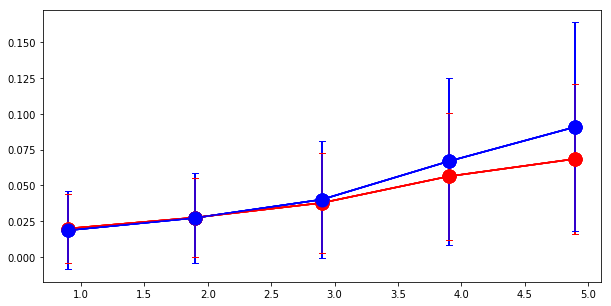

In [195]:
x = np.arange(1,6)


for j in [0,1,2,3,4]:
    print(j)
    plt.figure(figsize=(10,5))
    for i in x:
        plt.errorbar(x-0.1,[np.mean([rev[j] for rev in elite_sent_extrema[i]]) for i in x],
                 yerr=[np.std([rev[j] for rev in elite_sent_extrema[i]]) for i in x],
                 linestyle='-', marker='o',markersize=13,capsize=3,color='red')
        plt.errorbar(x-0.1,[np.mean([rev[j] for rev in reg_sent_extrema[i]]) for i in x],
                 yerr=[np.std([rev[j] for rev in reg_sent_extrema[i]]) for i in x],
                 linestyle='-', marker='o',markersize=13,capsize=3,color='blue')

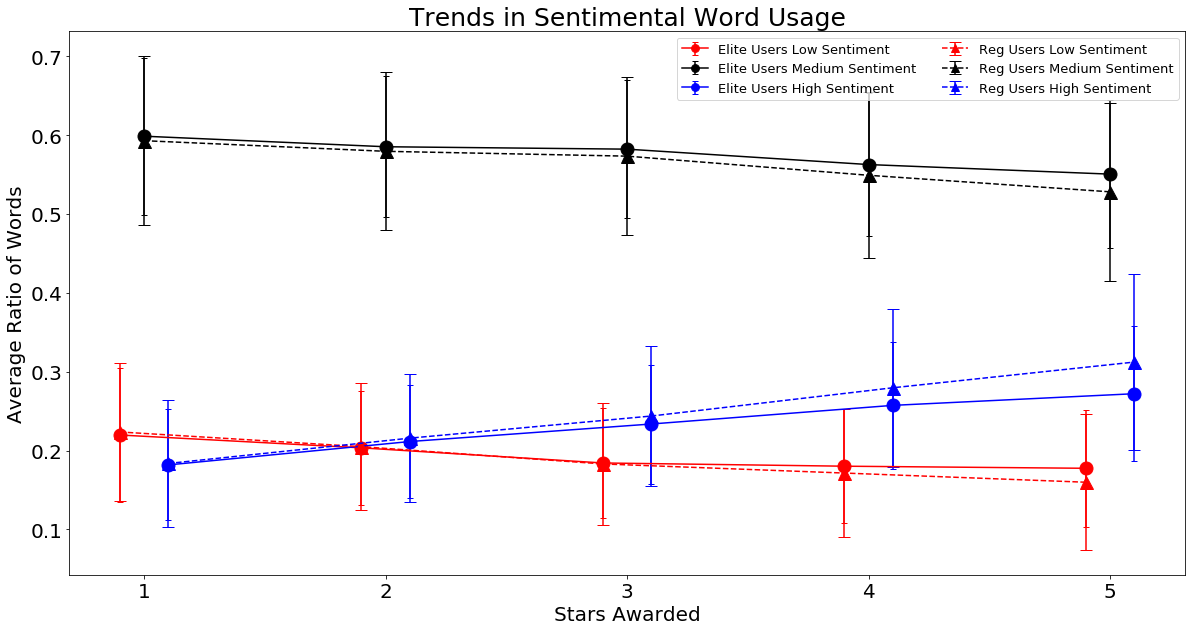

In [252]:
plt.figure(figsize=(20,10))
plt.title('Trends in Sentimental Word Usage',fontsize=25)
plt.xlabel('Stars Awarded',fontsize=20)
plt.ylabel('Average Ratio of Words',fontsize=20)
x = np.arange(1,6)

plt.errorbar(x-0.1,[np.mean([rev[0] for rev in elite_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[0] for rev in elite_sent_extrema[i]]) for i in x],
             linestyle='-', marker='o',markersize=13,capsize=3,color='red',label='Elite Users Low Sentiment')
plt.errorbar(x,[np.mean([rev[1] for rev in elite_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[1] for rev in elite_sent_extrema[i]]) for i in x],
             linestyle='-', marker='o',markersize=13,capsize=3,color='black',label='Elite Users Medium Sentiment')
plt.errorbar(x+0.1,[np.mean([rev[2] for rev in elite_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[2] for rev in elite_sent_extrema[i]]) for i in x],
             linestyle='-', marker='o',markersize=13,capsize=3,color='blue',label='Elite Users High Sentiment')

plt.errorbar(x-0.1,[np.mean([rev[0] for rev in reg_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[0] for rev in reg_sent_extrema[i]]) for i in x],
             linestyle='--', marker='^',markersize=13,capsize=6,color='red',label='Reg Users Low Sentiment')
plt.errorbar(x,[np.mean([rev[1] for rev in reg_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[1] for rev in reg_sent_extrema[i]]) for i in x],
             linestyle='--', marker='^',markersize=13,capsize=6,color='black',label='Reg Users Medium Sentiment')
plt.errorbar(x+0.1,[np.mean([rev[2] for rev in reg_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[2] for rev in reg_sent_extrema[i]]) for i in x],
             linestyle='--', marker='^',markersize=13,capsize=6,color='blue',label='Reg Users High Sentiment')

plt.legend(loc='upper right',ncol = 2,fontsize=13,markerscale=0.6)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

save = True
if save:
    plt.savefig("SentimentPlots/sentiment_wordcount.svg",  format="svg")
    
plt.show()

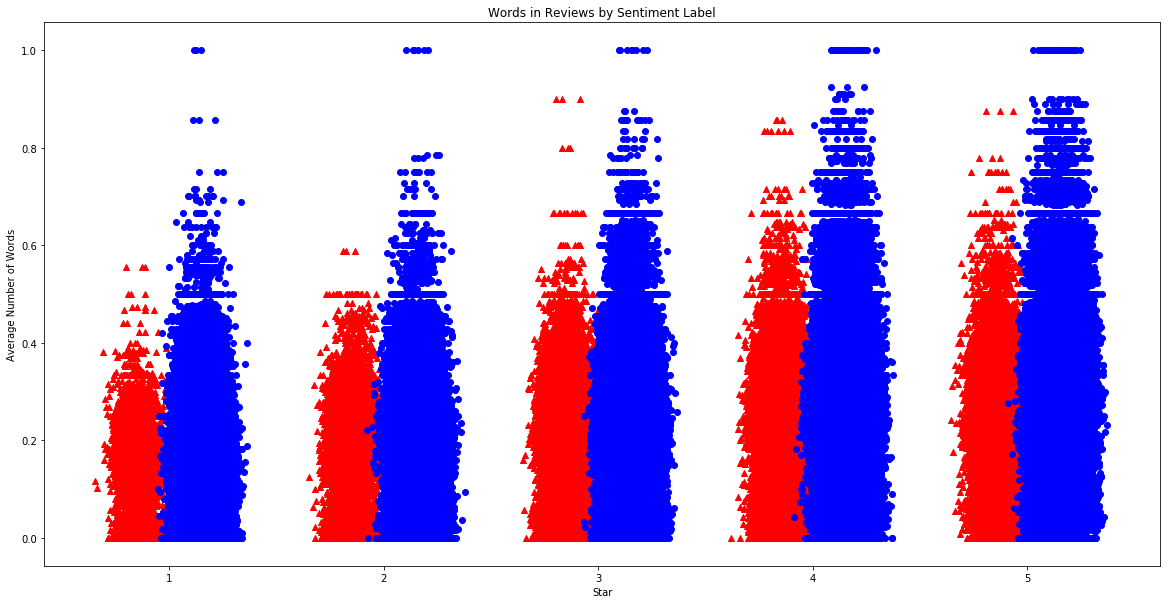

In [157]:
plt.figure(figsize=(20,10))
plt.title('Words in Reviews by Sentiment Label')
plt.xlabel('Star')
plt.ylabel('Average Number of Words')
x = np.arange(1,6)
k = 2
for i in x:
    plt.scatter(np.random.normal(i-0.15,0.05,len([a[k] for a in elite_sent_extrema[i]])),[a[k] for a in elite_sent_extrema[i]], marker='^',color='red',label='Elite Users Low Sentiment')
    plt.scatter(np.random.normal(i+0.15,0.05,len([a[k] for a in reg_sent_extrema[i]])),[a[k] for a in reg_sent_extrema[i]], marker='o',color='blue',label='Reg Users Low Sentiment')

plt.show()